In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
#sys.path.insert(0, '/Users/ammar.tareen/Desktop/Research_projects/mavenn2/')
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
data_df_full = pd.read_csv('../data/2022.05.15.ace2rbd/ace2rbd_raw_counts_lib1.csv')
y_cols = list(data_df_full.columns[8:])
cols = y_cols.copy()
cols.insert(0,'x')
data_df = data_df_full[cols].copy()
data_df.head(10)

,x,TiteSeq_01_bin1,TiteSeq_01_bin2,TiteSeq_01_bin3,TiteSeq_01_bin4,TiteSeq_02_bin1,TiteSeq_02_bin2,TiteSeq_02_bin3,TiteSeq_02_bin4,TiteSeq_03_bin1,...,TiteSeq_14_bin3,TiteSeq_14_bin4,TiteSeq_15_bin1,TiteSeq_15_bin2,TiteSeq_15_bin3,TiteSeq_15_bin4,TiteSeq_16_bin1,TiteSeq_16_bin2,TiteSeq_16_bin3,TiteSeq_16_bin4
0,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NITNLCPFGEVFSATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,0,0,0,0,0,1,...,0,0,21,0,0,0,17,0,0,0
2,NITNLCPFGEVFNATRFASVYCWNRKRISNCVADYSVLYNSASFST...,6,35,162,4,24,85,80,30,10,...,37,0,151,4,0,0,154,19,0,0
3,NITNLCPFGEVFFATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,1,3,439,1,0,14,307,17,...,82,0,180,12,0,12,306,20,0,0
4,NITNLKPFGEVFNAWRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,3,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
5,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,39,7,0,3,83,4,0,14,101,...,0,0,140,4,0,0,56,8,549,0
6,NITNLCPFGEVFNATRFVSVYAWNRKRISNCVADYSVLYNSASFST...,1,1,24,154,0,0,1,104,3,...,2,0,48,0,0,0,102,1,0,0
7,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,4,0,0,0,1,0,...,0,0,0,0,0,0,3,0,0,0
8,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,1,0,59,7,0,4,53,23,3,...,5,0,4,0,0,0,26,4,0,0
9,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,16,0,0,0,4,0,...,0,0,8,0,0,0,0,0,0,0


In [3]:
y_cols_1 = list(data_df_full.columns[8:12])
y_cols_2 = list(data_df_full.columns[68:72])

In [4]:
y = data_df[y_cols_1+y_cols_2]

In [5]:
X = data_df['x']
#y = data_df[y_cols]

In [6]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [7]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y',]


#Y = len(y_cols)
Y = 8
print(f'L={L}, Y={Y}')

L=201, Y=8


In [8]:
# instantiate gpmap object
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)



2022-06-06 11:56:38.659012: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# read in parameters

# number of reads in each bin summed
N_y = np.sum(y,axis=0)

In [10]:
print(N_y)

TiteSeq_01_bin1     2579236
TiteSeq_01_bin2     1157805
TiteSeq_01_bin3     1626103
TiteSeq_01_bin4     5929980
TiteSeq_16_bin1    10930706
TiteSeq_16_bin2      684127
TiteSeq_16_bin3     1299065
TiteSeq_16_bin4      254070
dtype: int64


#### I approximated these values from Fig 2B

In [11]:
bounds = np.log(np.array([[1,180],[180,1400],[1400,10500],[10500,250000]]))

bounds_df = pd.DataFrame(bounds,columns=['lower_bound','upper_bound'])
f_y_lower_bounds = bounds_df['lower_bound'].values
f_y_upper_bounds = bounds_df['upper_bound'].values
bounds_df

,lower_bound,upper_bound
0,0.000000,5.192957
1,5.192957,7.244228
2,7.244228,9.259131
3,9.259131,12.429216


I don't know how to obtain these values. I based them roughly on Figure 2 from Star et al

In [12]:
mu_neg = np.log(50)
mu_pos = np.log(70000)

# log10 variances
# sigma_neg = 1/3.
# sigma_pos = 1/3.

# sigma_neg = 0.5
# sigma_pos = 0.5

sigma_neg = 1.5
sigma_pos = 1.5



In [13]:
mu_pos, mu_neg

(11.156250521031495, 3.912023005428146)

In [14]:
f_y_upper_bounds

array([ 5.19295685,  7.24422752,  9.25913054, 12.4292162 ])

In [15]:
#np.arange(10**(-13),10**(-6),10**(-12))
cs = [0,10**(-13),10**(-12.5),
     10**(-12),10**(-11.5),
     10**(-11),10**(-10.5),
     10**(-10),10**(-9.5),
     10**(-9),10**(-8.5),
     10**(-8),10**(-7.5),
     10**(-7),10**(-6.5),
     10**(-6)]

#cs = [0,10**(-6)]
#cs = [0.1,0.2]

#cs = np.arange(0.1,1,0.06)

In [16]:
N_y[0:4]

TiteSeq_01_bin1    2579236
TiteSeq_01_bin2    1157805
TiteSeq_01_bin3    1626103
TiteSeq_01_bin4    5929980
dtype: int64

In [17]:
# mp_list = [mavenn.measurement_process_layers.TiteSeqMP(N_y=N_y[4*mp_idx:4*mp_idx+4],
#                                                          c=cs[mp_idx],
#                                                          Y=4,
#                                                          mu_pos=mu_pos,
#                                                          sigma_pos=sigma_pos,
#                                                          mu_neg=mu_neg,
#                                                          sigma_neg=sigma_neg,
#                                                          f_y_lower_bounds=f_y_lower_bounds,
#                                                          f_y_upper_bounds=f_y_upper_bounds,
#                                                          info_for_layers_dict={'H_y_norm':0},
#                                                          eta=1e-5,)
#            for mp_idx in range(len(y_cols)//4)
#           ]

In [18]:
N_y[4:8].values

array([10930706,   684127,  1299065,   254070])

In [19]:
TiteSeq_mp_1 = mavenn.measurement_process_layers.TiteSeqMP(N_y=N_y[0:4].values,
                                                         c=0.001,
                                                         Y=4,
                                                         mu_pos=mu_pos,
                                                         sigma_pos=sigma_pos,
                                                         mu_neg=mu_neg,
                                                         sigma_neg=sigma_neg,
                                                         f_y_lower_bounds=f_y_lower_bounds,
                                                         f_y_upper_bounds=f_y_upper_bounds,
                                                         info_for_layers_dict={'H_y_norm':0},
                                                         eta=1e-5,
                                                         )

TiteSeq_mp_2 = mavenn.measurement_process_layers.TiteSeqMP(N_y=N_y[4:8].values,
                                                         c=0.0011,
                                                         Y=4,
                                                         mu_pos=mu_pos,
                                                         sigma_pos=sigma_pos,
                                                         mu_neg=mu_neg,
                                                         sigma_neg=sigma_neg,
                                                         f_y_lower_bounds=f_y_lower_bounds,
                                                         f_y_upper_bounds=f_y_upper_bounds,
                                                         info_for_layers_dict={'H_y_norm':0},
                                                         eta=1e-5,
                                                         )

In [20]:
# model = mavenn.Model2(gpmap=gpmap,
#                       mp_list=mp_list)

model = mavenn.Model2(gpmap=gpmap,
                      mp_list=[TiteSeq_mp_1, TiteSeq_mp_2])

In [21]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 4028)]      0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 4020)         0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 additive_gp_map_layer (Additiv  (None, 1)           4021        ['Sequence_only[0][0]']          
 eGPMapLayer)                                                                                     
                                                                                              

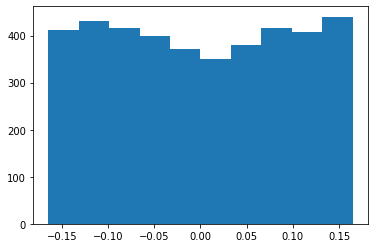

In [22]:
plt.hist(gpmap.get_weights()[1].ravel(),bins=10)
plt.show()

In [23]:
y_train[y_cols_2]

,TiteSeq_16_bin1,TiteSeq_16_bin2,TiteSeq_16_bin3,TiteSeq_16_bin4
24031,74,7,62,0
56510,0,0,0,0
25206,23,0,0,0
86263,27,1,0,0
46352,29,0,0,0
...,...,...,...,...
54727,18,1,0,0
31759,35,0,0,0
35250,785,33,0,0
609,171,11,0,0


In [24]:
# Set training data
model.set_data(x=x_train,
               
               y_list=[
                       y_train[y_cols_1].values,
                       y_train[y_cols_2].values,                                                       
                      ],

               shuffle=False)

N = 83,880 observations set as training data.
Using 20.3% for validation.
Time to set data: 28.0 sec.


In [25]:
# from tensorflow.keras.utils import plot_model
# plot_model(model.model,show_shapes=True,show_dtype=False,dpi=200,to_file='titeseq_mp_2_heads.png')

In [26]:

# Fit model to data
model.fit(learning_rate=.001,
          epochs=50,
          batch_size=200,
          try_tqdm = False,
          early_stopping=False,
          early_stopping_patience=10,
          linear_initialization=False)

Epoch 1/50
335/335 [==============================] - 11s 22ms/step - loss: 363856.8125 - tite_seq_mp_loss: 306895.2500 - tite_seq_mp_1_loss: 56961.6367 - I_var: -2.0917 - val_loss: 376179.9375 - val_tite_seq_mp_loss: 309678.1562 - val_tite_seq_mp_1_loss: 66501.7969 - val_I_var: -2.3899
Epoch 2/50
335/335 [==============================] - 4s 11ms/step - loss: 363077.0938 - tite_seq_mp_loss: 306507.6562 - tite_seq_mp_1_loss: 56569.5508 - I_var: -2.0867 - val_loss: 375422.3750 - val_tite_seq_mp_loss: 309208.6562 - val_tite_seq_mp_1_loss: 66213.6484 - val_I_var: -2.3757
Epoch 3/50
335/335 [==============================] - 4s 12ms/step - loss: 362319.7188 - tite_seq_mp_loss: 305980.1875 - tite_seq_mp_1_loss: 56339.4219 - I_var: -2.0324 - val_loss: 374105.7500 - val_tite_seq_mp_loss: 308383.0000 - val_tite_seq_mp_1_loss: 65722.7188 - val_I_var: -2.3515
Epoch 4/50
335/335 [==============================] - 3s 10ms/step - loss: 360915.4375 - tite_seq_mp_loss: 305170.3750 - tite_seq_mp_1_los

Epoch 30/50
335/335 [==============================] - 3s 9ms/step - loss: 84926.3828 - tite_seq_mp_loss: 58110.2734 - tite_seq_mp_1_loss: 26815.4180 - I_var: -0.4970 - val_loss: 107483.5391 - val_tite_seq_mp_loss: 71840.2109 - val_tite_seq_mp_1_loss: 35642.6055 - val_I_var: -0.8614
Epoch 31/50
335/335 [==============================] - 3s 10ms/step - loss: 82711.8672 - tite_seq_mp_loss: 55568.9258 - tite_seq_mp_1_loss: 27142.1289 - I_var: -0.5256 - val_loss: 109349.4141 - val_tite_seq_mp_loss: 74747.8906 - val_tite_seq_mp_1_loss: 34600.6797 - val_I_var: -0.8039
Epoch 32/50
335/335 [==============================] - 3s 9ms/step - loss: 81052.0000 - tite_seq_mp_loss: 53784.0156 - tite_seq_mp_1_loss: 27267.0664 - I_var: -0.5227 - val_loss: 104732.2266 - val_tite_seq_mp_loss: 68313.2031 - val_tite_seq_mp_1_loss: 36418.1289 - val_I_var: -0.9018
Epoch 33/50
335/335 [==============================] - 4s 11ms/step - loss: 79768.2891 - tite_seq_mp_loss: 52206.3984 - tite_seq_mp_1_loss: 27560.8

On test data:


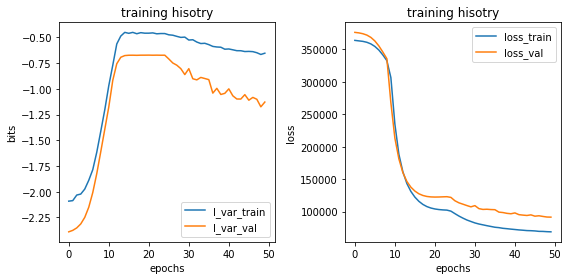

In [27]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, axs = plt.subplots(1,2,figsize=[8,4])

ax = axs[0]
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
#ax.set_xscale('log')
ax.set_title('training hisotry')

ax = axs[1]
ax.plot(model.history['loss'], label='loss_train')
ax.plot(model.history['val_loss'], label='loss_val')
# ax.set_xlim(100,300)
# ax.set_ylim(0.7*1e6,0.8*1e6)
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_title('training hisotry')
fig.tight_layout()

In [28]:
#phi = gpmap.x_to_phi(x_test)
gpmap.weights[1].numpy().shape

(1, 201, 20)

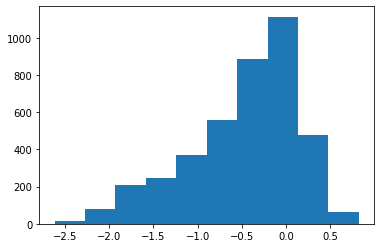

In [29]:
plt.hist(gpmap.get_weights()[1].ravel(),bins=10)
plt.show()

In [30]:
phi = gpmap.x_to_phi(x_test)
theta = np.squeeze(gpmap.weights[1].numpy())


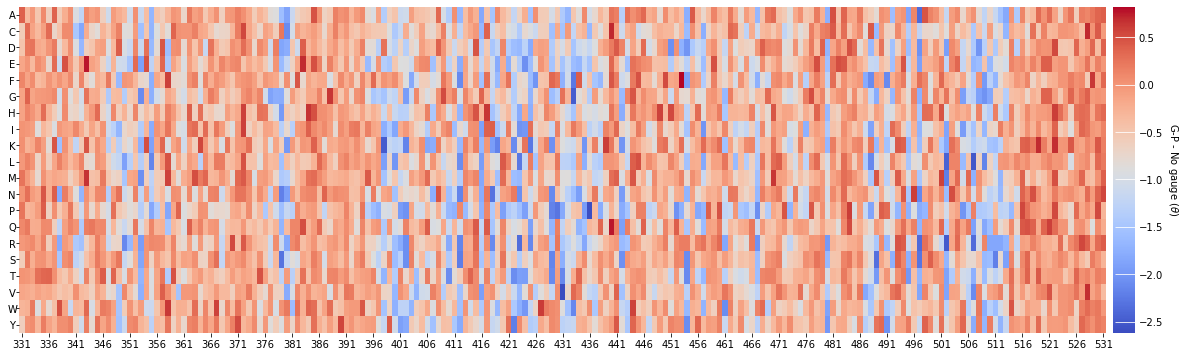

In [48]:

# # Create fig and ax objects
fig, ax = plt.subplots(figsize=[20,6])

# Draw heatmap
ax, cb = mavenn.heatmap(values=theta,
                        alphabet='protein',
                        ax=ax,
                        #gpmap_type='additive',
                        #cmap='RdBu',
                        #clim = [-5,1],
                        cmap_size='2%')

# Style heatmap
ax.set_xticks(np.arange(0,201,5))
ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])
#ax.set_xlabel('nucleotide position', labelpad=5)

# Style colorbar
cb.set_label('G-P - No gauge ($\\theta$)',
             labelpad=10, ha='center', va='center', rotation=-90)
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')

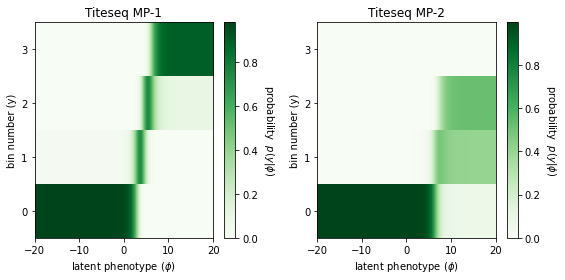

In [32]:
# Get G-P map parameters in matrix form


# Create grid in phi space
phi_lim = [-20, 20]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = 4    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values



# Create figure with two panels
fig, axs = plt.subplots(1,2,figsize=[8,4])

mp_counter = 0
for i in range(2):
        
        measurement_process = [TiteSeq_mp_1, TiteSeq_mp_2][mp_counter].p_of_y_given_phi(y_all, phi_grid)
        # Right panel: draw measurement process as heatmap
        ax = axs[i]

        im = ax.imshow(measurement_process,
                       cmap='Greens',
                       extent=phi_lim+y_lim,
                       vmin=0,
                       origin='lower',
                       interpolation='nearest',
                       aspect="auto")
        ax.set_yticks(y_all)
        ax.set_ylabel('bin number (y)')
        ax.set_xlabel('latent phenotype ($\phi$)')
        ax.set_title(f'Titeseq MP-{mp_counter+1}')
        mp_counter+=1
        
        cb = plt.colorbar(im,ax=ax)
        cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")
fig.tight_layout()

#fig.savefig('ace2rbd_mpa_measurment_prcoess_expression_monotonic.png',dpi=300,bbox_inches='tight')


In [33]:
bloom_single_mut_df = pd.read_csv('single_mut_effects_Bloom.txt')

bloom_bind_df = pd.DataFrame(columns=alphabet)
for site in range(1,201+1,):

    temp_df = bloom_single_mut_df[bloom_single_mut_df['site_RBD']==site].copy()
    #temp_df['bind_lib1']
    #expr_lib1
    bloom_bind_df.loc[site-1] = temp_df['bind_avg'].values[0:20]

bloom_bind_df.head()


,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,-0.03,-0.09,0.03,0.00,-0.10,-0.04,-0.02,-0.07,-0.01,-0.05,-0.02,0.00,-0.03,0.01,-0.02,-0.03,0.06,-0.04,-0.16,-0.06
1,0.00,-0.09,-0.02,0.08,-0.22,-0.08,0.04,0.00,-0.05,0.00,0.00,0.00,0.06,-0.02,0.00,-0.04,-0.03,0.00,-0.03,-0.03
2,-0.01,-0.14,-0.01,-0.15,-0.15,-0.07,-0.07,-0.06,-0.01,-0.01,-0.02,-0.06,0.03,0.02,0.00,-0.08,0.00,-0.05,-0.21,-0.07
3,-0.03,-0.11,0.07,0.01,-0.22,-0.03,-0.02,-0.20,-0.03,-0.20,-0.05,0.00,-0.18,0.01,0.00,-0.06,-0.04,-0.07,-0.24,-0.09
4,0.04,-0.11,0.00,0.06,-0.03,-0.08,-0.03,-0.02,-0.03,0.00,0.01,0.03,0.06,-0.02,-0.01,0.01,0.02,-0.08,-0.05,-0.02


In [34]:
bloom_single_mut_df = pd.read_csv('single_mut_effects_Bloom.txt')
bloom_exp_df = pd.DataFrame(columns=alphabet)
for site in range(1,201+1,):

    temp_df = bloom_single_mut_df[bloom_single_mut_df['site_RBD']==site].copy()
    temp_df['expr_lib1']
    bloom_exp_df.loc[site-1] = temp_df['expr_avg'].values[0:20]
    
bloom_exp_df.head()    

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,-0.11,-1.26,-0.44,-0.31,-0.70,-0.25,-0.61,-0.85,-0.20,-0.75,-0.75,0.00,-0.21,-0.53,-0.44,-0.33,-0.34,-0.61,-1.12,-1.02
1,0.00,-0.12,0.03,0.01,-0.10,0.14,0.05,0.00,-0.06,-0.03,-0.02,0.05,-0.17,0.07,-0.04,-0.03,-0.04,0.02,-0.33,-0.07
2,-0.37,-0.93,-0.27,-0.31,-0.89,-0.41,-0.29,-1.03,-0.20,-0.55,-0.47,-0.35,-0.28,-0.35,-0.54,-0.04,0.00,-0.56,-0.63,-0.62
3,-0.12,-0.57,-0.04,-0.05,-0.97,-0.21,-0.12,-0.67,-0.02,-0.72,-0.40,0.00,-0.55,-0.08,-0.12,-0.19,-0.02,-0.47,-1.01,-0.61
4,-0.01,-0.38,-0.09,0.11,-0.16,-0.16,-0.10,-0.16,0.02,0.00,-0.15,-0.08,0.09,-0.05,-0.14,-0.08,-0.08,-0.10,-0.13,-0.12


In [35]:
theta_df = pd.DataFrame(theta,columns=alphabet)

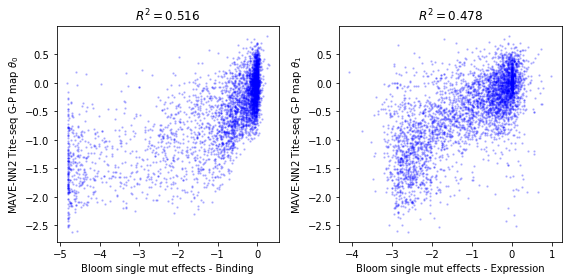

In [36]:
fig, axs = plt.subplots(1,2, figsize=(8,4))
Rsq_0 = np.corrcoef(bloom_bind_df.fillna(0).values.ravel(), theta_df.fillna(0).values.ravel())[0,1]**2
ax = axs[0]
ax.scatter(bloom_bind_df.values.ravel(), theta_df.fillna(0).values.ravel(),s=2,alpha=0.2,color='blue')
bloom_bind_df
lims = [-5,1]
#plt.plot(lims,lims,'--')
ax.set_xlabel('Bloom single mut effects - Binding')
ax.set_title(f'$R^2 = {Rsq_0:.3f}$')
ax.set_ylabel('MAVE-NN2 Tite-seq G-P map $\\theta_0$')

Rsq_1 = np.corrcoef(bloom_exp_df.fillna(0).values.ravel(), theta_df.fillna(0).values.ravel())[0,1]**2
ax = axs[1]
#ax.scatter(logo_bloomd.df.values, theta_1_df.values,s=2.5,alpha=0.25,color='blue')
ax.scatter(bloom_exp_df.values.ravel(),theta_df.fillna(0).values.ravel(),s=2,alpha=0.2,color='blue')

#bloom_exp_df
# bloom_bind_df

lims = [-5,1]
#ax.plot(lims,lims,'--')
ax.set_xlabel('Bloom single mut effects - Expression')
ax.set_title(f'$R^2 = {Rsq_1:.3f}$')
ax.set_ylabel('MAVE-NN2 Tite-seq G-P map $\\theta_1$')

fig.tight_layout()

In [37]:
theta_lc = gpmap.get_theta(model,gauge='consensus')['theta_lc']
theta_lc_consensus_df = pd.DataFrame(theta_lc,columns=alphabet)

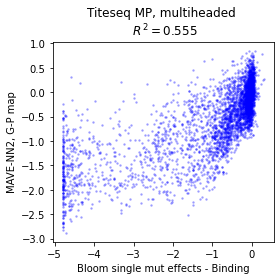

In [38]:
plt.figure(figsize=(4,4))
Rsq = np.corrcoef(bloom_bind_df.fillna(0).values.ravel(), theta_lc_consensus_df.fillna(0).values.ravel())[0,1]**2
plt.scatter(bloom_bind_df.values, theta_lc_consensus_df.values,s=2.5,alpha=0.25,color='blue')

#lims = [-5,1]
#plt.plot(lims,lims,'--',color='gray',zorder=-1)
plt.xlabel('Bloom single mut effects - Binding')
plt.title(f'Titeseq MP, multiheaded \n $R^2 = {Rsq:.3f}$')
plt.ylabel('MAVE-NN2, G-P map')
plt.tight_layout()
#plt.savefig('mavenn_bloom_binding_comparison.png',dpi=200,bbox_inches='tight')

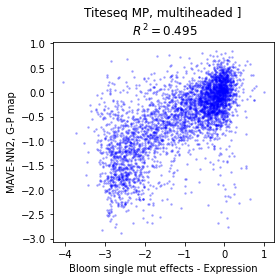

In [39]:
plt.figure(figsize=(4,4))
Rsq = np.corrcoef(bloom_exp_df.fillna(0).values.ravel(), theta_lc_consensus_df.fillna(0).values.ravel())[0,1]**2
plt.scatter(bloom_exp_df.values, theta_lc_consensus_df.values,s=2.5,alpha=0.25,color='blue')

#lims = [-5,1]
#plt.plot(lims,lims,'--',color='gray',zorder=-1)
plt.xlabel('Bloom single mut effects - Expression')
plt.title(f'Titeseq MP, multiheaded ]\n $R^2 = {Rsq:.3f}$')
plt.ylabel('MAVE-NN2, G-P map')
plt.tight_layout()
#plt.savefig('mavenn_bloom_binding_comparison.png',dpi=200,bbox_inches='tight')